In [51]:
# Problem Statement: Predict the taxi fare given the source, destination and number of passengers in New York City

In [2]:
# Importing libraries:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
# Loading the data:

In [4]:
data_file = r'C:\Users\AnitaM\Downloads\New York City Taxi Fare\train.csv'

In [5]:
nyfare = pd.read_csv(data_file)

In [6]:
nyfare.shape

(50000, 8)

In [7]:
nyfare.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
# Data Cleaning and Feature Engineering:

In [9]:
nyfare.drop(['key'], axis=1, inplace=True)

In [10]:
nyfare.drop(nyfare[nyfare['pickup_latitude']==0].index, inplace=True)

In [11]:
from geopy import distance

In [12]:
nyfare.drop(nyfare[nyfare['pickup_latitude']>90].index, inplace=True) # the latitude range has to be in -90 to 90 range

In [13]:
nyfare.reset_index(drop=True, inplace=True)

In [14]:
for i in range(len(nyfare)):
    pickup = (nyfare['pickup_latitude'][i], nyfare['pickup_longitude'][i])
    dropoff = (nyfare['dropoff_latitude'][i], nyfare['dropoff_longitude'][i])
    nyfare.loc[i, 'Distance_inMiles'] = distance.distance(pickup, dropoff).miles

In [15]:
nyfare.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance_inMiles
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.639764
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,5.246511
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.863167
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,1.737223
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.241710


In [16]:
nyfare.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

In [17]:
nyfare['pickup_datetime'] = pd.to_datetime(nyfare['pickup_datetime'], infer_datetime_format=True)
nyfare.head()

,fare_amount,pickup_datetime,passenger_count,Distance_inMiles
0,4.5,2009-06-15 17:26:21,1,0.639764
1,16.9,2010-01-05 16:52:16,1,5.246511
2,5.7,2011-08-18 00:35:00,2,0.863167
3,7.7,2012-04-21 04:30:42,1,1.737223
4,5.3,2010-03-09 07:51:00,1,1.241710


In [18]:
nyfare['pickup_time_year'] = pd.DatetimeIndex(nyfare['pickup_datetime']).year
nyfare['pickup_time_month'] = pd.DatetimeIndex(nyfare['pickup_datetime']).month
nyfare['pickup_time_weekday'] = pd.DatetimeIndex(nyfare['pickup_datetime']).weekday
nyfare['pickup_time_hour'] = pd.DatetimeIndex(nyfare['pickup_datetime']).hour

In [19]:
nyfare.head()

,fare_amount,pickup_datetime,passenger_count,Distance_inMiles,pickup_time_year,pickup_time_month,pickup_time_weekday,pickup_time_hour
0,4.5,2009-06-15 17:26:21,1,0.639764,2009,6,0,17
1,16.9,2010-01-05 16:52:16,1,5.246511,2010,1,1,16
2,5.7,2011-08-18 00:35:00,2,0.863167,2011,8,3,0
3,7.7,2012-04-21 04:30:42,1,1.737223,2012,4,5,4
4,5.3,2010-03-09 07:51:00,1,1.241710,2010,3,1,7


In [20]:
del nyfare['pickup_datetime']

In [21]:
nyfare.dtypes

fare_amount            float64
passenger_count          int64
Distance_inMiles       float64
pickup_time_year         int64
pickup_time_month        int64
pickup_time_weekday      int64
pickup_time_hour         int64
dtype: object

In [22]:
nyfare_train, nyfare_test = train_test_split(nyfare, test_size=0.2, random_state=2)

In [23]:
nyfare_train.shape

(39235, 7)

In [24]:
nyfare_test.shape

(9809, 7)

In [25]:
x_train = nyfare_train.drop('fare_amount', 1)
y_train = nyfare_train['fare_amount']

x_test = nyfare_test.drop('fare_amount', 1)
y_test = nyfare_test['fare_amount']

In [26]:
lr_model = LinearRegression(fit_intercept=True)

In [27]:
lr_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
mean_absolute_error(y_train, lr_model.predict(x_train))

5.974861837324321

In [29]:
mean_absolute_error(y_test, lr_model.predict(x_test))

5.902396276346595

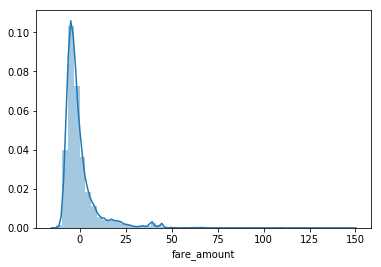

In [30]:
sns.distplot(y_test-(lr_model.predict(x_test)))

In [31]:
params = {'criterion' : ['mse', 'mae'],
          'max_depth' : [5,10,15,20],
          'max_features' : [1,2,3,4]
}

In [32]:
random_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=2),
                                  param_distributions=params,
                                  cv=10,
                                  scoring='neg_mean_absolute_error')

In [33]:
random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=2,
                                                   splitter='best'),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_dist

In [34]:
dtree_model = random_search.best_estimator_

In [35]:
mean_absolute_error(y_train, dtree_model.predict(x_train))

1.896382311711482

In [36]:
mean_absolute_error(y_test, dtree_model.predict(x_test))

2.196728004893465

In [37]:
params = {'booster' : ['gbtree','gblinear','dart'],
          'learning_rate' : [0.1,0.5,1]}

In [38]:
random_search = RandomizedSearchCV(XGBRegressor(subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8),
                                   param_distributions=params,
                                   cv=10,
                                   random_state=2,
                                   scoring='neg_mean_absolute_error', verbose=True)

In [39]:
random_search.fit(x_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:17:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bytree, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:17:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bytree, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:17:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bytree,

[15:17:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bytree, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:17:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bytree, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:17:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bytree,

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  6.0min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=0.8,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_cons...
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=0.8,
                                          tree_method=None,
                                  

In [40]:
xgb_model = random_search.best_estimator_

In [41]:
mean_absolute_error(y_train, xgb_model.predict(x_train))

1.9575000649684702

In [42]:
mean_absolute_error(y_test, xgb_model.predict(x_test))

2.1277343840097864

In [46]:
rf_model1 = RandomForestRegressor(criterion='mae', max_depth=15, max_features=4, n_estimators=200, min_impurity_split=0.1)

In [47]:
rf_model1.fit(x_train,y_train)

C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: T

C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: T

C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: T

C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: T

C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: T

C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: T

C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: T

C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\AnitaM\Anaconda3\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: T

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=15,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=0.1,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [52]:
mean_absolute_error(y_train, rf_model1.predict(x_train))

1.4018336905823885

In [53]:
mean_absolute_error(y_test, rf_model1.predict(x_test))

2.1008321566928334

In [58]:
import pickle
# open a file, where you ant to store the data
file = open('FarePred_xgb.pkl', 'wb')

# dump information to that file
pickle.dump(xgb_model, file)